# 3 RNN Implementation: Poem Generation

## Matin Ghaffari, A16617005

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import re
import random
import time
import math

# 3A Pre-processing

# 3A i.

#### Explain your choices of data pre-processing, as well as why you chose these choices initially. What was your final pre-processing? How did you tokenize your words, and split up the data into separate sequences? What changed as you continued on your project? What did you try that didn’t work?

### For data pre-processing I initially began by reading in all 154 sonnets and contacting each line of every sonnet together. Afterwards I used Regex to remove all punctuation and symbols and lower casing everything. After this I performed tokenization by encoding every unique character to a index which is ultimately turned into a one-hot vector. At first I wrote my own code to perform one-hot encoding, however i later learned I could use nn.Embedding within my RNN class to accomplish this as well which I used for my final model. Also at first I tried preprocessing the CMU dictionary and I was able to get a list of syllables per word, however I had trouble implementing this within my model after trying for many hours, so i ended up not doing this. For my final pre-processing I decided to keep capitalized letters and most symbols/punctuations except dashes and parenthesis since based off my analysis I found these important for the learning of sentence structure, since each sonnet line starts with a capital letter and since most sonnet lines end with puncations such as ',' , '.' , ':' , '?'. However I did remove dashes and parenthesis in order for my model to better learn words without error since there arn't many occurances of these which consequently makes it harder for the model to learn without significant error. At first I split up the data into separate sequences where each sequence was a line of a sonnet with the newline character removed, however as I continued to work on this project I decided to keep the data as a single string and leaving the newline characters in order for the model to better learn sentence structure since I implemented a random batch method that is splits up the data into sequences of 40 characters depending on the the batch size passed in. 

In [2]:
######################################################
# Initial Preprocessing to get text as entire string
####################################################

path = "poem_data/shakespeare.txt"
file = open(path, "r")
ll = []

for line in file:
    ll.append(line.lstrip())

file.close()

lines = []
for i in ll:
    if i != '\n' and not i.strip().isdigit() and i:
        lines.append(i)
        
data = ''.join(lines)
data

"From fairest creatures we desire increase,\nThat thereby beauty's rose might never die,\nBut as the riper should by time decease,\nHis tender heir might bear his memory:\nBut thou contracted to thine own bright eyes,\nFeed'st thy light's flame with self-substantial fuel,\nMaking a famine where abundance lies,\nThy self thy foe, to thy sweet self too cruel:\nThou that art now the world's fresh ornament,\nAnd only herald to the gaudy spring,\nWithin thine own bud buriest thy content,\nAnd tender churl mak'st waste in niggarding:\nPity the world, or else this glutton be,\nTo eat the world's due, by the grave and thee.\nWhen forty winters shall besiege thy brow,\nAnd dig deep trenches in thy beauty's field,\nThy youth's proud livery so gazed on now,\nWill be a tattered weed of small worth held:\nThen being asked, where all thy beauty lies,\nWhere all the treasure of thy lusty days;\nTo say within thine own deep sunken eyes,\nWere an all-eating shame, and thriftless praise.\nHow much more 

In [3]:
############################################################################################################
# After conducting exploratory data analysis I decided to keep capitalized letters and most
# symbols/punctuations except dashes and parenthesis since based off my analysis I found these important
# for the learning of sentence structure, since each sonnet line starts with a capital letter and since
# most sonnet lines end with puncations such as ',' , '.' , ':' , '?'. However I did remove dashes and
# parenthesis in order for my model to better learn words without error since there arn't many occurances
# of these which consequently is harder for the model to learn without significant error.
############################################################################################################

################################################
#   Initial choice of preprocessing
################################################
#data =' '.join(data).strip()
#data = re.sub(r'\d{1,}', '', data)
#data = re.sub(r'\s{2,}', ' ', data).strip()
#data = re.sub(r'[();:,.!?]', '', data).strip()
################################################

# Final preprocessing 
text = re.sub(r'[()-]', '', data).strip()
chars = tuple(set(text))
n_chars = len(chars)

char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

In [4]:
char_to_ix

{'r': 0,
 'D': 1,
 'B': 2,
 '?': 3,
 'U': 4,
 'c': 5,
 's': 6,
 'b': 7,
 '.': 8,
 'n': 9,
 'L': 10,
 'e': 11,
 'm': 12,
 'f': 13,
 'u': 14,
 ' ': 15,
 'Y': 16,
 'V': 17,
 't': 18,
 'P': 19,
 'p': 20,
 'W': 21,
 ',': 22,
 'K': 23,
 'z': 24,
 'a': 25,
 'v': 26,
 "'": 27,
 '!': 28,
 'x': 29,
 'J': 30,
 'R': 31,
 'F': 32,
 'H': 33,
 'E': 34,
 'g': 35,
 'T': 36,
 'N': 37,
 '\n': 38,
 'i': 39,
 'S': 40,
 'h': 41,
 'q': 42,
 'G': 43,
 'A': 44,
 'l': 45,
 'y': 46,
 'I': 47,
 'w': 48,
 'C': 49,
 ':': 50,
 'M': 51,
 'k': 52,
 'd': 53,
 ';': 54,
 'o': 55,
 'O': 56,
 'j': 57}

# 3A.ii 
#### Write about any data analysis you did on the dataset to help you make these decisions. Perform statistical analysis of the data and visualize them.

### For my data analysis and visualization I created bar plots to show the most common words, the frequency of unique characters, most common starting and end character (not including newline character) for sonnet lines, average sonnet length, average line length. After conducting these exploratory data analysis I decided to keep capitalized letters and most symbols/punctuation except dashes and parenthesis since based off my analysis I found these important for the learning of sentence structure, since each sonnet line starts with a capital letter and since most sonnet lines end with punctuation such as ',' , '.' , ':' , '?'. However I did remove dashes and parenthesis in order for my model to better learn words without error since there aren't many occurrences of these which consequently is harder for the model to learn and generalize without significant error.

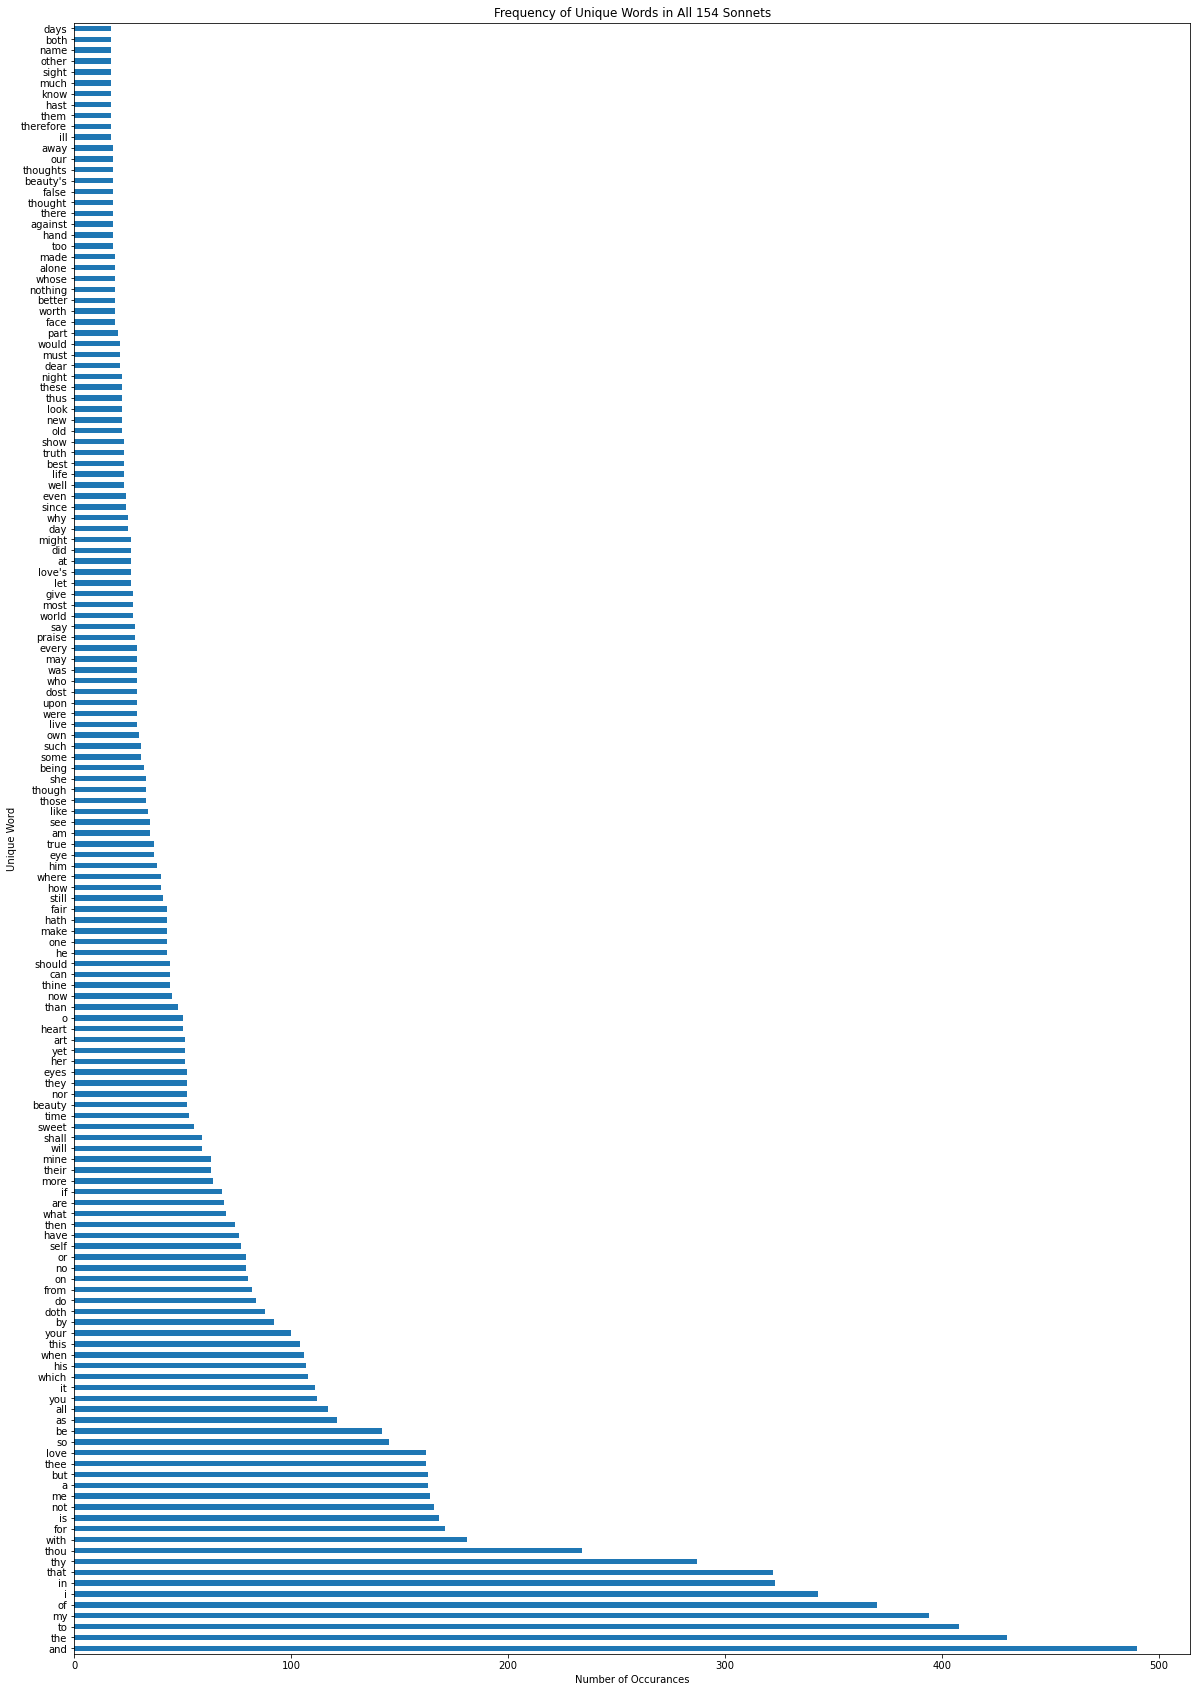

In [5]:
b=re.findall(r"\b.+\b", ''.join(ll))
b =' '.join(b).strip()
b = re.sub(r'\d{1,}', '', b)
b = re.sub(r'\s{2,}', ' ', b).strip()
b = re.sub(r'[();:,.!?]', '', b).strip()
words = list(filter(None, re.split(r' ', b)))
words = [w.lower() for w in words]
pd.Series(words).value_counts()[:150].plot(kind='barh',figsize=(20,30));
plt.title("Frequency of Unique Words in All 154 Sonnets")
plt.xlabel('Number of Occurances')
plt.ylabel('Unique Word');

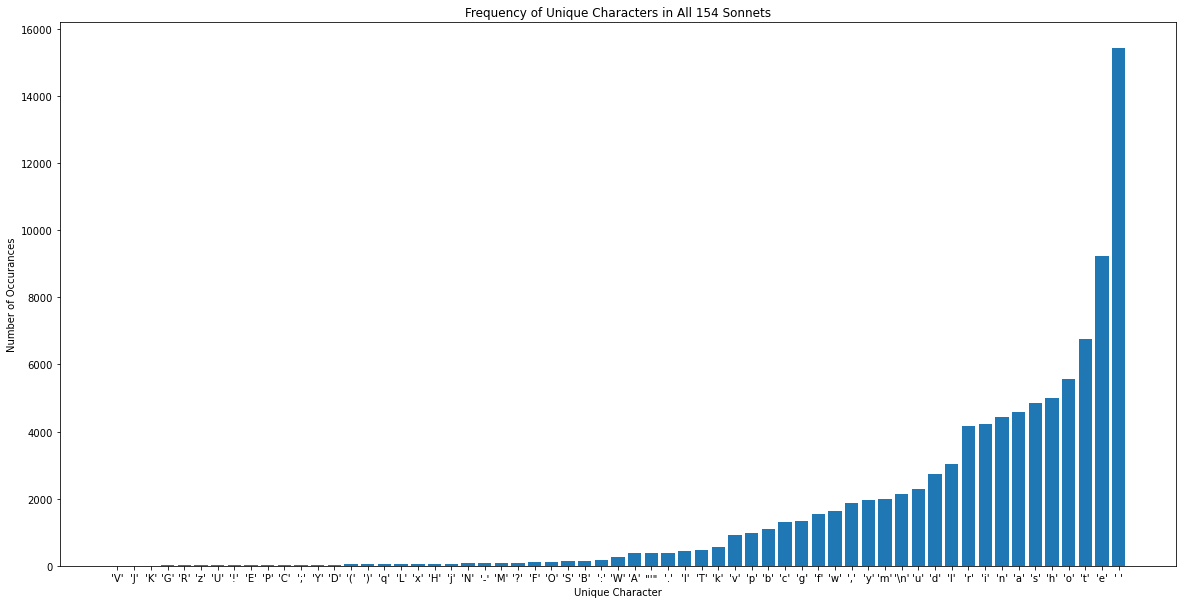

Number of Unique Characters: 61


In [6]:
dic = {i : data.count(i) for i in set(data)}
sort_dic = sorted(dic.items(), key=lambda x: x[1])

x, y = zip(*sort_dic)
x = [repr(i) for i in x]

plt.figure(figsize=(20,10))
plt.bar(x, y)
plt.title("Frequency of Unique Characters in All 154 Sonnets")
plt.ylabel('Number of Occurances')
plt.xlabel('Unique Character')
plt.show()

print(f'Number of Unique Characters: {len(x)}')

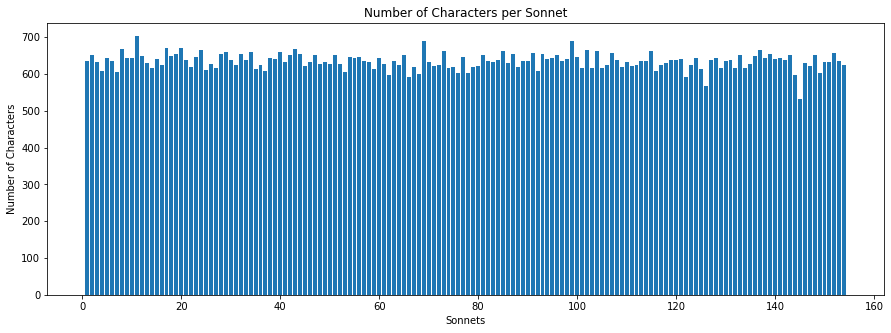

Maximum sonnet length: 703.00 characters
Minimum sonnet length: 533.00 characters
Average sonnet length: 634.56 characters


In [7]:
sonnets = open('poem_data/shakespeare.txt').read().split('\n\n')
sonnet_lens = [len(sonnet) for sonnet in sonnets]

plt.figure(figsize=(15, 5))
plt.bar([i for i in range(1, len(sonnets)+1)], sonnet_lens)
plt.title('Number of Characters per Sonnet')
plt.ylabel('Number of Characters')
plt.xlabel('Sonnets')
plt.show()

print('Maximum sonnet length: %.2f characters' % np.max(sonnet_lens))
print('Minimum sonnet length: %.2f characters' % np.min(sonnet_lens))
print('Average sonnet length: %.2f characters' % np.mean(sonnet_lens))

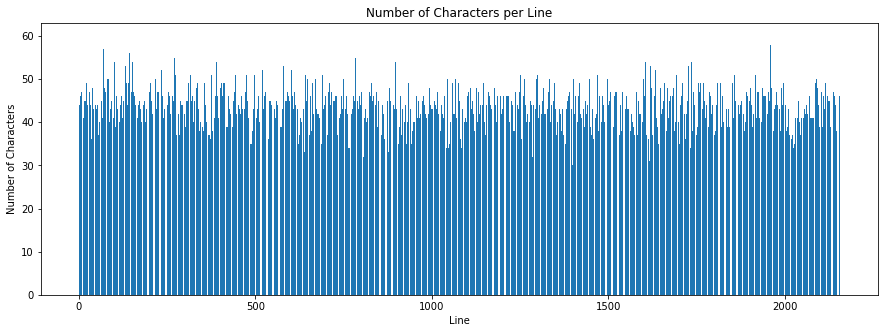

Maximum Line length: 60.00 characters
Minimum Line length: 30.00 characters
Average Line length: 43.47 characters


In [8]:
line_lens = [len(l) for l in lines]

plt.figure(figsize=(15, 5))
plt.bar([i for i in range(1, len(lines)+1)], line_lens)
plt.title('Number of Characters per Line')
plt.ylabel('Number of Characters')
plt.xlabel('Line')
plt.show()


print('Maximum Line length: %.2f characters' % np.max(line_lens))
print('Minimum Line length: %.2f characters' % np.min(line_lens))
print('Average Line length: %.2f characters' % np.mean(line_lens))

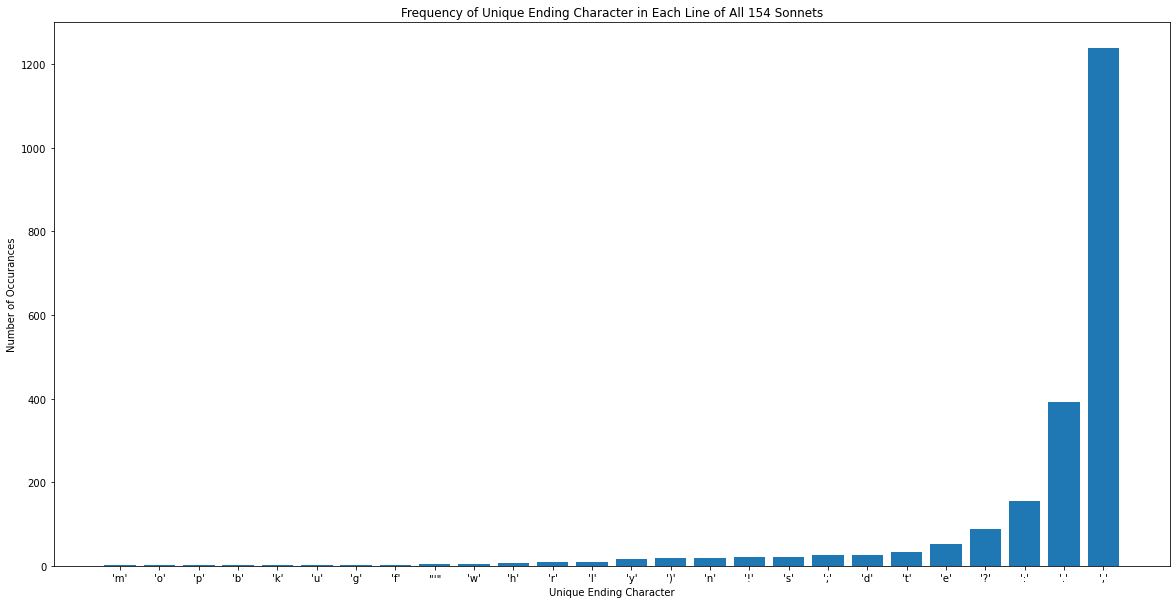

In [9]:
from collections import Counter
ends = [x[-2] for x in lines]
dic = dict(Counter(ends))

# last_chars = [x[-2] for x in lines]
# dic = {i : data.count(i) for i in last_chars}
sort_dic = sorted(dic.items(), key=lambda x: x[1])

x, y = zip(*sort_dic)
x = [repr(i) for i in x]

plt.figure(figsize=(20,10))
plt.bar(x, y)
plt.title("Frequency of Unique Ending Character in Each Line of All 154 Sonnets")
plt.ylabel('Number of Occurances')
plt.xlabel('Unique Ending Character')
plt.show()

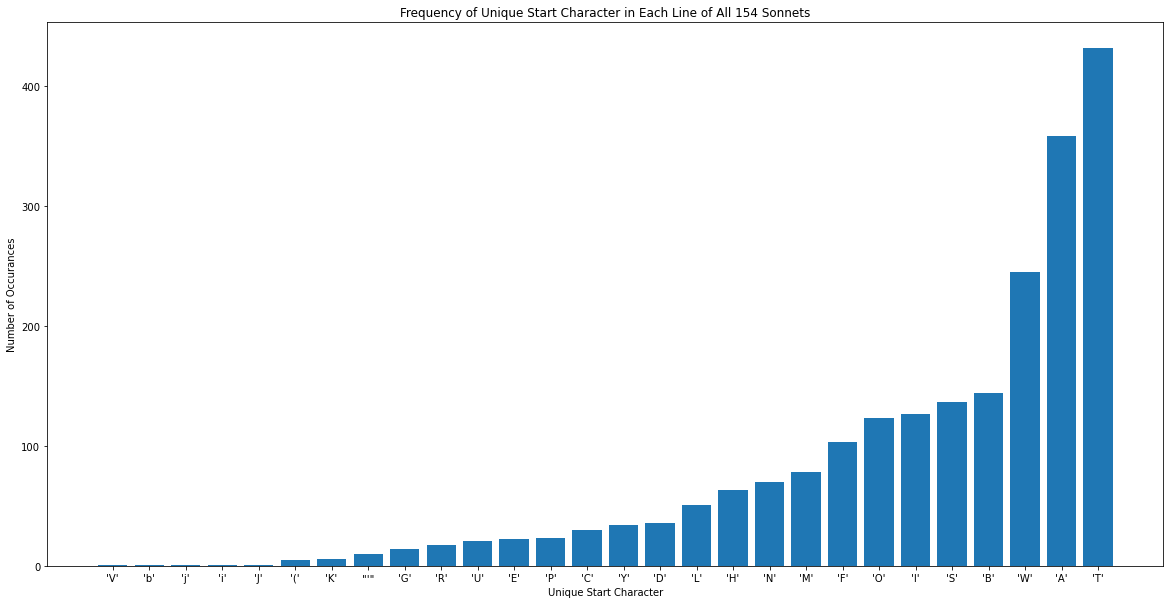

In [10]:
starts = [x[0] for x in lines]
dic = dict(Counter(starts))

sort_dic = sorted(dic.items(), key=lambda x: x[1])

x, y = zip(*sort_dic)
x = [repr(i) for i in x]

plt.figure(figsize=(20,10))
plt.bar(x, y)
plt.title("Frequency of Unique Start Character in Each Line of All 154 Sonnets")
plt.ylabel('Number of Occurances')
plt.xlabel('Unique Start Character')
plt.show()

# 3B i.
#### Explain in detail what model you implemented? What parameters did you tune? Comment on the poems that your model produced.

### My character-based LSTM model implemented a RNN which uses nn.Embedding to get one-hot vectorized input characters, and has a single hidden layer of 200 LSTM units with a fully connected output layer. My model also implements random batching in order to control the number of training samples used to estimate of the error gradient. Furthermore I used cross entropy loss as the loss function and for the optimizer I used was Adam after I found it performing much better than stochastic gradient descent. When generating poems I implemented a predict function that predicts a given number of characters using a given seed as a string using a softmax nonlinearity to find the most probable next character by first using the characters the seed and the predicting the next character based off the previous last character of the seed and the previous last character generated. <br><br> The parameters that I tuned were batch_size, learning rate, number of LSTM units, and number of epochs. For batch size I tried sizes 1, 2, 4, 8, 16, 32, 64, and 128 and I found that a batch size of 128 resulted in the best performance in terms of loss and the quality of poems generated. For learning rate I tried 0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005, 0.0009, and 0.00001 and I found that 0.0009 produce the best performance in terms of training time, loss, and the quality of poems generated. For the number of LSTM units i tried 100, 128, 164, and 200 and found 200 resulted in the best lost and quality of poems generated. Lastly i tried number of epochs of 100, 500, 1000, 5000, and 10000 and found the 10000 was best since thats when the loss began converging near ~ .60 . <br><br> The poems that my model produced appear to have learned sentence structure and sonnet structure since most of the times each line is about 40 characters and each line properly starts with a capitalized character and often ends with a puncuation such as ',' , '.' , ':' , '?', which we know is proper based on our analysis above. The poems generated often have several mispelled words, however, it does appear to make somewhat sense logically and grammatically via propper punctuation.

In [11]:
#####################################################################################
# Sources: https://d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html, 
# https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html,
# https://www.youtube.com/watch?v=WujVlF_6h5A&t=444s and discussion sections
#####################################################################################

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size,hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        out = self.embed(x)
        out, (hidden, cell) = self.lstm(out.unsqueeze(1), (hidden, cell))
        out = self.fc(out.reshape(out.shape[0], -1))
        return out, (hidden, cell)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return hidden, cell
    

In [12]:
############################################################
# Configure Device to train on GPU else CPU if not available
############################################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
#############################################################
# Defining helper functions for training my model
#############################################################

def lineToTensor(line):
    tensor = torch.zeros(len(line)).long()
    for char in range(len(line)):
        tensor[char] = chars.index(line[char])
    return tensor
    
    
def randomBatch(text, batch_size, sequence_len):
    x = torch.zeros(batch_size, sequence_len)
    y = torch.zeros(batch_size, sequence_len)

    for i in range(batch_size):
        strt = random.randint(0, len(text) - sequence_len - 1)
        end = strt + sequence_len + 1
        txt = text[strt:end]
        x[i, :] = lineToTensor(txt[:-1])
        y[i, :] = lineToTensor(txt[1:])

    return x.long(), y.long()


def train(text, sequence_len, n_epochs, batch_size, hidden_size, output_size, n_layers, lr, temperature):
    
    rnn = RNN(n_chars, hidden_size, n_layers, n_chars).to(device)

    optimizer = torch.optim.Adam(rnn.parameters(), lr)
    criterion = nn.CrossEntropyLoss()
    
    training_size = 0

    for epoch in range(1, n_epochs + 1):
        
        hidden, cell = rnn.init_hidden(batch_size)
        
        x, y = randomBatch(text, batch_size, sequence_len)
        x = x.to(device)
        y = y.to(device)
        
        loss = 0
        rnn.zero_grad()
        
        for char in range(sequence_len):
            output, (hidden, cell) = rnn(x[:, char], hidden, cell)
            loss += criterion(output, y[:, char])

        loss.backward()
        optimizer.step()
        loss = loss.item() / sequence_len
        
        training_size += sequence_len * batch_size

        if epoch % 500 == 0:
            print(f'---------------------------------------------------------')
            print(f"Epoch: {epoch}")
            print(f"Loss : {loss}")
            print(f'# of characters used by train: {training_size}')
            print(f'---------------------------------------------------------')
#            print(f'Actual Sequence')
#            print(f'-------------------')
#            print(''.join([ix_to_char[i] for i in y.cpu().numpy()[0]]))
#            print(f'-------------------')
#            print(f'Predicted Sequence')
#            print(f'-------------------')
#            print(''.join(predict(rnn, x.cpu().numpy()[0][-1], 40, 1)))
#            print(predict(rnn, ''.join([ix_to_char[i] for i in x.cpu().numpy()[0]]), 40, 1))
            print(predict(rnn, "shall i compare thee to a summer's day?\n",n_chars_out = output_size, temperature = temperature))
            print(f'---------------------------------------------------------\n')
    
    return rnn, training_size


def predict(rnn, seed, n_chars_out, temperature):
    hidden, cell = rnn.init_hidden(1) 
    tensor_seed = lineToTensor(seed)
    prediction = seed

    for ch in range(len(tensor_seed) - 1):
        _, (hidden, cell) = rnn(tensor_seed[ch].view(1).to(device), hidden, cell)

    prev_char = tensor_seed[-1]
    
    for _ in range(n_chars_out):
        output, (hidden, cell) = rnn(prev_char.view(1).to(device), hidden, cell)

        output = F.softmax(output/temperature, dim=-1)
        index = torch.multinomial(output, 1)[0] #Categorical(output).sample()

        prediction +=  chars[index]
        prev_char = lineToTensor(chars[index])

    return prediction


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


# 3B ii. 
#### Does the LSTM successfully learn sentence structure and/or sonnet structure? Report the runtime/amount of training data needed.

### The LSTM succesfully learns sentence structure and sonnet structure for the most part. The sonnets my LSTM generate appear to have learned sentence structure and sonnet structure since most of the times each line is about 40 characters and each line properly starts with a capitalized character and often ends with a puncuation such as ',' , '.' , ':' , '?', which we know is proper based on our analysis above. The total run time was 15 minutes and 50 seconds when using 10,000 epochs, learning rate of 0.0009, batch size of 128, and and sequence length of 40. The training data used was the 154 sonnets (93504 total characters and 58 unique characters) that were trained, which I trained over 10,000 epochs with batch size of 128 and sequence size of 40.

In [14]:
sequence_len = 40
batch_size = 128
hidden_size = 200
n_layers = 1
output_size = 200
lr = 0.0009
temperature = 1
n_epochs = 10000

start = time.time()

rnn, training_size = train(text, sequence_len, n_epochs, batch_size, hidden_size, output_size, n_layers, lr, temperature)

print("**********************************************************************************************************")
print(f"Total Trianing Time for {n_epochs} epochs with learning rate of {lr} : {timeSince(start)}")
print(f"{training_size} total characters trained using {batch_size} batch size and with a sequence size of {sequence_len}")
print(f"The data used had {len(text)} total characters and {len(chars)} unique characters from 154 Sonnets")
print("**********************************************************************************************************")

---------------------------------------------------------
Epoch: 500
Loss : 1.606583023071289
# of characters used by train: 2560000
---------------------------------------------------------
shall i compare thee to a summer's day?
Thy ame thy of husive?Th unribst or my trauge,
Tast,
That rough hadowed, and aspearss dechending,
For those vinther versed a though fairs pey:
Not love face to brumph that thigh should qupices should 
---------------------------------------------------------

---------------------------------------------------------
Epoch: 1000
Loss : 1.4057921409606933
# of characters used by train: 5120000
---------------------------------------------------------
shall i compare thee to a summer's day?
ent my heart that on behold seppeit dear!
Then has part in my gests not for praise:
So live that not see odour that men wronk bound atters maners whereomich which hoply did had mine,
Upon they if weal
---------------------------------------------------------

----------------

# 3B iii.
#### Include generated poems using temperatures of 1.5, 0.75, and 0.25 with the following initial 40-character seed: “shall i compare thee to a summer’s day?\n”, and comment on their differences.

### When reading about temperatures and softmax online, I learned that the temperature is used to change the output distribution computed by my neural net. Thus, when using a higher temperature the distribution will be 'softer' meaning the model will be less confident about it's prediction while a smaller temperature will have a harder 'distribution' meaning the model is more confident about its predictions.<br><br> Thus this reasoning appears to be quite consistent with the poems I generate using temperatures of 1.5, 0.75, 0.25; since it appears a larger temperature like 1.5 produces the most diverse text and has the most errors (much more mispellings and much worst sentence stucture and punctuation) as it is less confident on its pedictions, and smaller temperatures like 0.25 poduces more repetive poems and has less errors (repeated 'love' four times, had no mispellings, and best sentence structure) as it is more confident about the predictions, and 0.75 seems to be a middle ground between 1.5 and 0.25 since it has much less errors than 1.5, but slightly more errors than 0.25, however it isn't as reptetive as 0.25.

In [19]:
temperature = 1.5

pred = predict(rnn, "shall i compare thee to a summer's day?\n", output_size, temperature = temperature)
print(pred)

shall i compare thee to a summer's day?
Or whether better it selse with April zeast that you due, yet kindness,
Pitity'n grace it strandelese no state to our, and meads, delights tenpies this, your if I found they where your equalies of wel


In [16]:
temperature = 0.75

pred = predict(rnn, "shall i compare thee to a summer's day?\n", output_size, temperature = temperature)
print(pred)

shall i compare thee to a summer's day?
Thou art my false age unsed lives a sent'st leaves shalt be death, that my dead;
But that who hate's sometime art once unden time?
Than thoughts, some wancounded, and dear love was fair were barrent's


In [17]:
temperature = 0.25

pred = predict(rnn, "shall i compare thee to a summer's day?\n", output_size, temperature = temperature)
print(pred)

shall i compare thee to a summer's day?
Thou art my love that time do I now for a look,
Possessing of love, with a farther and errors not almost tell my new,
Come dear love no more shall death brag thou art all the better part of my love, t
